In [221]:

import sysid
import sysid.subspace
import time
import pandas as pd
import cupy as np
import numpy
import matplotlib.pyplot as plt

In [222]:
tf = 30  # 365 * 5
dt = 1
plot_stuff = True

data_u = np.random.randn(10, tf)  # 40 * 45
data_y = np.random.randn(8, tf) + 10  # 40 * 45
print("data_u.shape: {}, data_y.shape: {}".format(data_u.shape, data_y.shape))
print("MIMO [{} IN, {} OUT], {} time-steps.".format(data_u.shape[0], data_y.shape[0], data_u.shape[1]))

def f_prbs_4d(t, x, i):
    return np.array([data_u[:, i]], dtype=numpy.float16).T

start_time = time.time()  # Serial
ss3_id = sysid.subspace_det_algo1(y=data_y, u=data_u,
    f=5,  # 5 Forward steps
    p=5,  # 5 Backward steps
    s_tol=0.01,  # 0.2
    dt=dt,
    order=-1)
print("--- GPU Execution time:\t\t{} seconds".format(time.time() - start_time))

data_u.shape: (10, 30), data_y.shape: (8, 30)
MIMO [10 IN, 8 OUT], 30 time-steps.
--- GPU Execution time:		0.05540871620178223 seconds


In [223]:
data3_id = ss3_id.simulate(
    f_u=f_prbs_4d,
    x0=np.array([np.zeros(ss3_id.A.shape[0])], dtype=numpy.float16).T,
    tf=tf)

fit 2.2246993993237347%


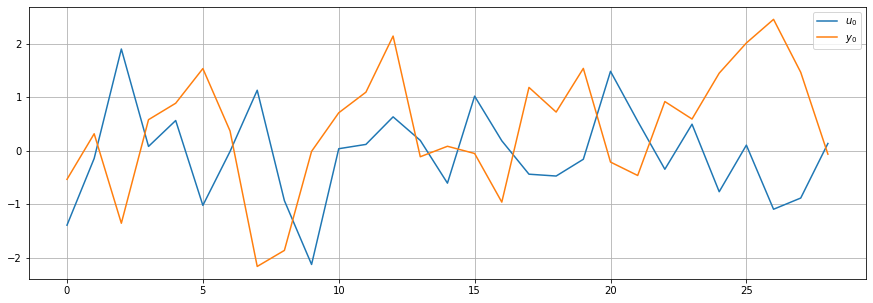

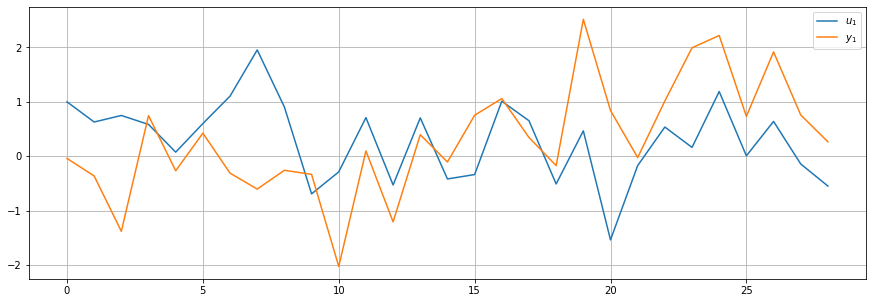

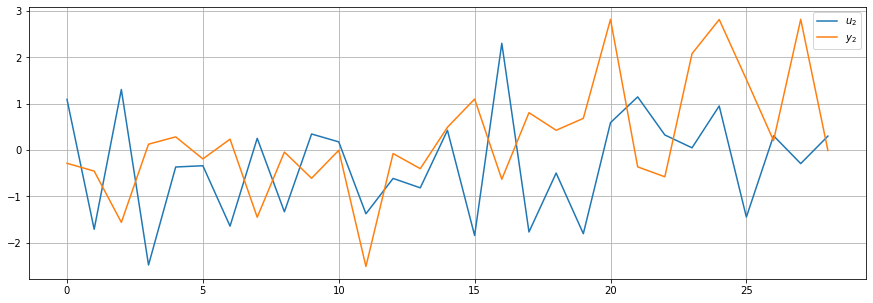

In [224]:
timesteps = data3_id.t.tolist()
for i in range(3):    
    plt.figure(figsize=(15,5))
    plt.plot(timesteps, data3_id.u[:,i,:][0].tolist(), label='$u_{:d}$'.format(i))
    plt.plot(timesteps, data3_id.y[:,i,:][0].tolist(), label='$y_{:d}$'.format(i))    
    plt.legend()
    plt.grid()

print('fit {}%'.format(100*sysid.subspace.nrms(data3_id.y, data_y[:, -1:])))

In [225]:
data3_id.y[0, i]
data_y[i, :]

array([ 9.98802647,  8.69826581,  8.68061767,  9.77622436,  9.6535459 ,
       10.32515246,  9.88758311,  9.06361593,  9.47870743, 10.15930463,
       10.54672642,  7.47991991, 10.28058498,  9.72538339, 10.56166565,
       11.1798021 ,  9.40675279, 10.56623609, 10.19981108, 10.36055394,
       12.46139139,  9.20985122,  9.12522308, 11.74626997, 12.16081431,
       10.54475217,  9.83657133, 11.44406414,  9.2268386 ,  8.9683027 ])

In [226]:
data_y.shape
data3_id.y.shape[:, i, :][0].shape

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
print('fit {}%'.format(100*sysid.subspace.nrms(data3_id.u[:,i,:][0], data_y[i,1:])))
# data3_id.u[:,i,:][0].shape

In [ ]:
y_true = np.array(data_y[i,1:], dtype=numpy.float32)
y_true

In [ ]:
y_pred = np.array(data3_id.y[:,i,:][0], dtype=numpy.float32)
y_pred

In [ ]:
def nrms2(data_fit, data_true):
    """
    Normalized root mean square error.
    """
    # root mean square error
    rms = np.mean(np.linalg.norm(data_fit - data_true, axis=0))

    # normalization factor is the max - min magnitude, or 2 times max dist from mean
    norm_factor = 2 * np.linalg.norm(data_true - np.mean(data_true, axis=1), axis=0).max()

    return (norm_factor - rms)/norm_factor

In [ ]:
data_fit = y_pred
data_true = y_true
rms = np.mean(np.linalg.norm(data_fit - data_true, axis=0))
rms
norm_factor = 2 * np.linalg.norm(data_true - np.mean(data_true, axis=1), axis=0).max()
# nrms2(y_true, y_pred)

In [ ]:
data_fit = y_pred
data_true = y_true

mse = ((data_true - data_fit)**2).mean(axis=None)
mse

rmse = np.sqrt(((data_true - data_fit)**2).mean(axis=None))
rmse

In [ ]:
# https://nl.mathworks.com/help/ident/ref/goodnessoffit.html
mse = np.linalg.norm(data_true - data_fit)**2 / data_fit.shape[0]
mse

In [ ]:
y_true = np.array(data_y[i,1:], dtype=numpy.float32)
y_true

In [ ]:
sum = 0
for i in range(8):   
    data_fit = np.array(data3_id.y[:,i,:][0], dtype=numpy.float32)
    data_true = np.array(data_y[i,1:], dtype=numpy.float32)
    
    nrmse = (np.linalg.norm(data_true - data_fit))/(np.linalg.norm(data_true - np.mean(data_true)))
    sum += nrmse
    print(nrmse)
print("mean sum", sum/8)    

In [ ]:
data_fit = np.array(data3_id.y[:,:][0], dtype=numpy.float32)
data_true = np.array(data_y[:,1:], dtype=numpy.float32)
    
nrmse_calc = (np.linalg.norm(data_true - data_fit))/(np.linalg.norm(data_true - np.mean(data_true)))
print(nrmse_calc, nrmse(data_fit, data_true), nrms(data_fit, data_true))

In [234]:
def nrms(data_fit, data_true):
    """
    Normalized root mean square error.
    See: https://nl.mathworks.com/help/ident/ref/goodnessoffit.html
    """

    # root_mean_squared_error = np.mean(np.linalg.norm(data_fit - data_true, axis=0), dtype=numpy.float16)  # RMSE
    # normalization_factor = 2 * np.linalg.norm(data_true - np.mean(data_true, axis=1), axis=0).max()
    # return (normalization_factor - root_mean_squared_error) / normalization_factor

    return (np.linalg.norm(data_true - data_fit))/(np.linalg.norm(data_true - np.mean(data_true)))

In [ ]:
def nrmse(data_fit, data_true):
    """
    Normalized root mean square error.
    See: https://nl.mathworks.com/help/ident/ref/goodnessoffit.html
    """
    return (np.linalg.norm(data_true - data_fit))/(np.linalg.norm(data_true - np.mean(data_true)))

In [ ]:
print(1 - sysid.subspace.nrms(np.array([[1, 2, 3]]), np.array([[1, 2, 3]])), 1 - nrmse(np.array([[1, 2, 3]]), np.array([[1, 2, 3]])), 1 - nrmse(np.array([[1, 2, 3]]), np.array([[0.1, 2.1, 3.35]])), 1 - nrmse(np.array([[1, 2, 3], [1, 2, 3]]), np.array([[0.1, 2.1, 3.35], [1, 2, 3]])), (1.0 +  0.58) / 2)

In [ ]:
sysid.subspace.nrms(np.array([[1, 2, 3]]), np.array([[1, 2, 3.1]]))

In [ ]:
1 - nrms(np.array([[1, 2, 3], [1, 2, 3]]), np.array([[1, 2, 3], [0.1, 2.1, 3.35], ]))